# Gaussian process regression on Mauna Loa CO2
The example is based on Section 5.4.3 of Gaussian Processes for Machine Learning by C. Rasmussen and C. Williams.  
This notebook also demonstrate simple usage of model persistence.

In [1]:
import gpie
print(gpie.__version__)

0.2.0


In [2]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.datasets import fetch_openml
from gpie.kernel import ConstantKernel, WhiteKernel, RBFKernel, \
    RationalQuadraticKernel, PeriodicKernel, GaussianProcessRegressor

In [3]:
# load Mauna Loa CO2 dataset
dataset = fetch_openml(data_id=41187)
months = dataset.data[:, 0] + (dataset.data[:, 1] - 1) / 12
ppmvs = dataset.target

In [4]:
# average ppmv observations for each calendar month
X, y, c = list(), list(), list()
for month, ppmv in zip(months, ppmvs):
    if not X or month != X[-1]:  # new month
        X.append(month)
        y.append(ppmv)
        c.append(1)
    else:  # same month
        y[-1] += ppmv
        c[-1] += 1

# input: time
X = np.array(X).reshape((-1, 1))
# target: demeaned monthly average CO2
y = np.array(y) / np.array(c)
t = y - y.mean()

In [5]:
# handcraft a composite kernel based on expert knowledge
# long-term trend
k1 = 30.0**2 * RBFKernel(l=200.0)
# seasonal variations
k2 = 3.0**2 * RBFKernel(l=200.0) * PeriodicKernel(p=1.0, l=1.0)
# medium-term irregularities
k3 = 0.5**2 * RationalQuadraticKernel(m=0.8, l=1.0)
# noise
k4 = 0.1**2 * RBFKernel(l=0.1) + 0.2**2 * WhiteKernel()
# composite kernel
kernel = k1 + k2 + k3 + k4
print(kernel)

30**2 * RBFKernel(l=200) + 3**2 * RBFKernel(l=200) * PeriodicKernel(p=1, l=1) + 0.5**2 * RationalQuadraticKernel(m=0.8, l=1) + 0.1**2 * RBFKernel(l=0.1) + 0.2**2 * WhiteKernel


In [6]:
# model persistence
saved_model = Path('gpr-co2.pkl')
if saved_model.is_file():  # load saved GPR model from disk
    with open(saved_model, 'rb') as f:
        gpr = pickle.load(f)
else:                      # train a new GPR on data
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(X, t)
                           # save trained GPR to disk
    with open(saved_model, 'wb') as f:
        pickle.dump(gpr, f, protocol=5)
gpr

GaussianProcessRegressor(kernel=43.4**2 * RBFKernel(l=51.5) + 2.47**2 * RBFKernel(l=104) * PeriodicKernel(p=1, l=1.44) + 0.542**2 * RationalQuadraticKernel(m=3.13, l=0.975) + 0.19**2 * RBFKernel(l=0.123) + 0.191**2 * WhiteKernel)

In [7]:
# predict target
X_ = np.linspace(X.max(), X.max() + 30, 300)[:, np.newaxis]
posterior = gpr.posterior_predictive(X_)
t_mu_pred, t_cov_pred = posterior.mu, posterior.cov
t_std_pred = np.sqrt(np.diag(t_cov_pred))
# add back empirical mean
y_mu_pred, y_std_pred = t_mu_pred + y.mean(), t_std_pred

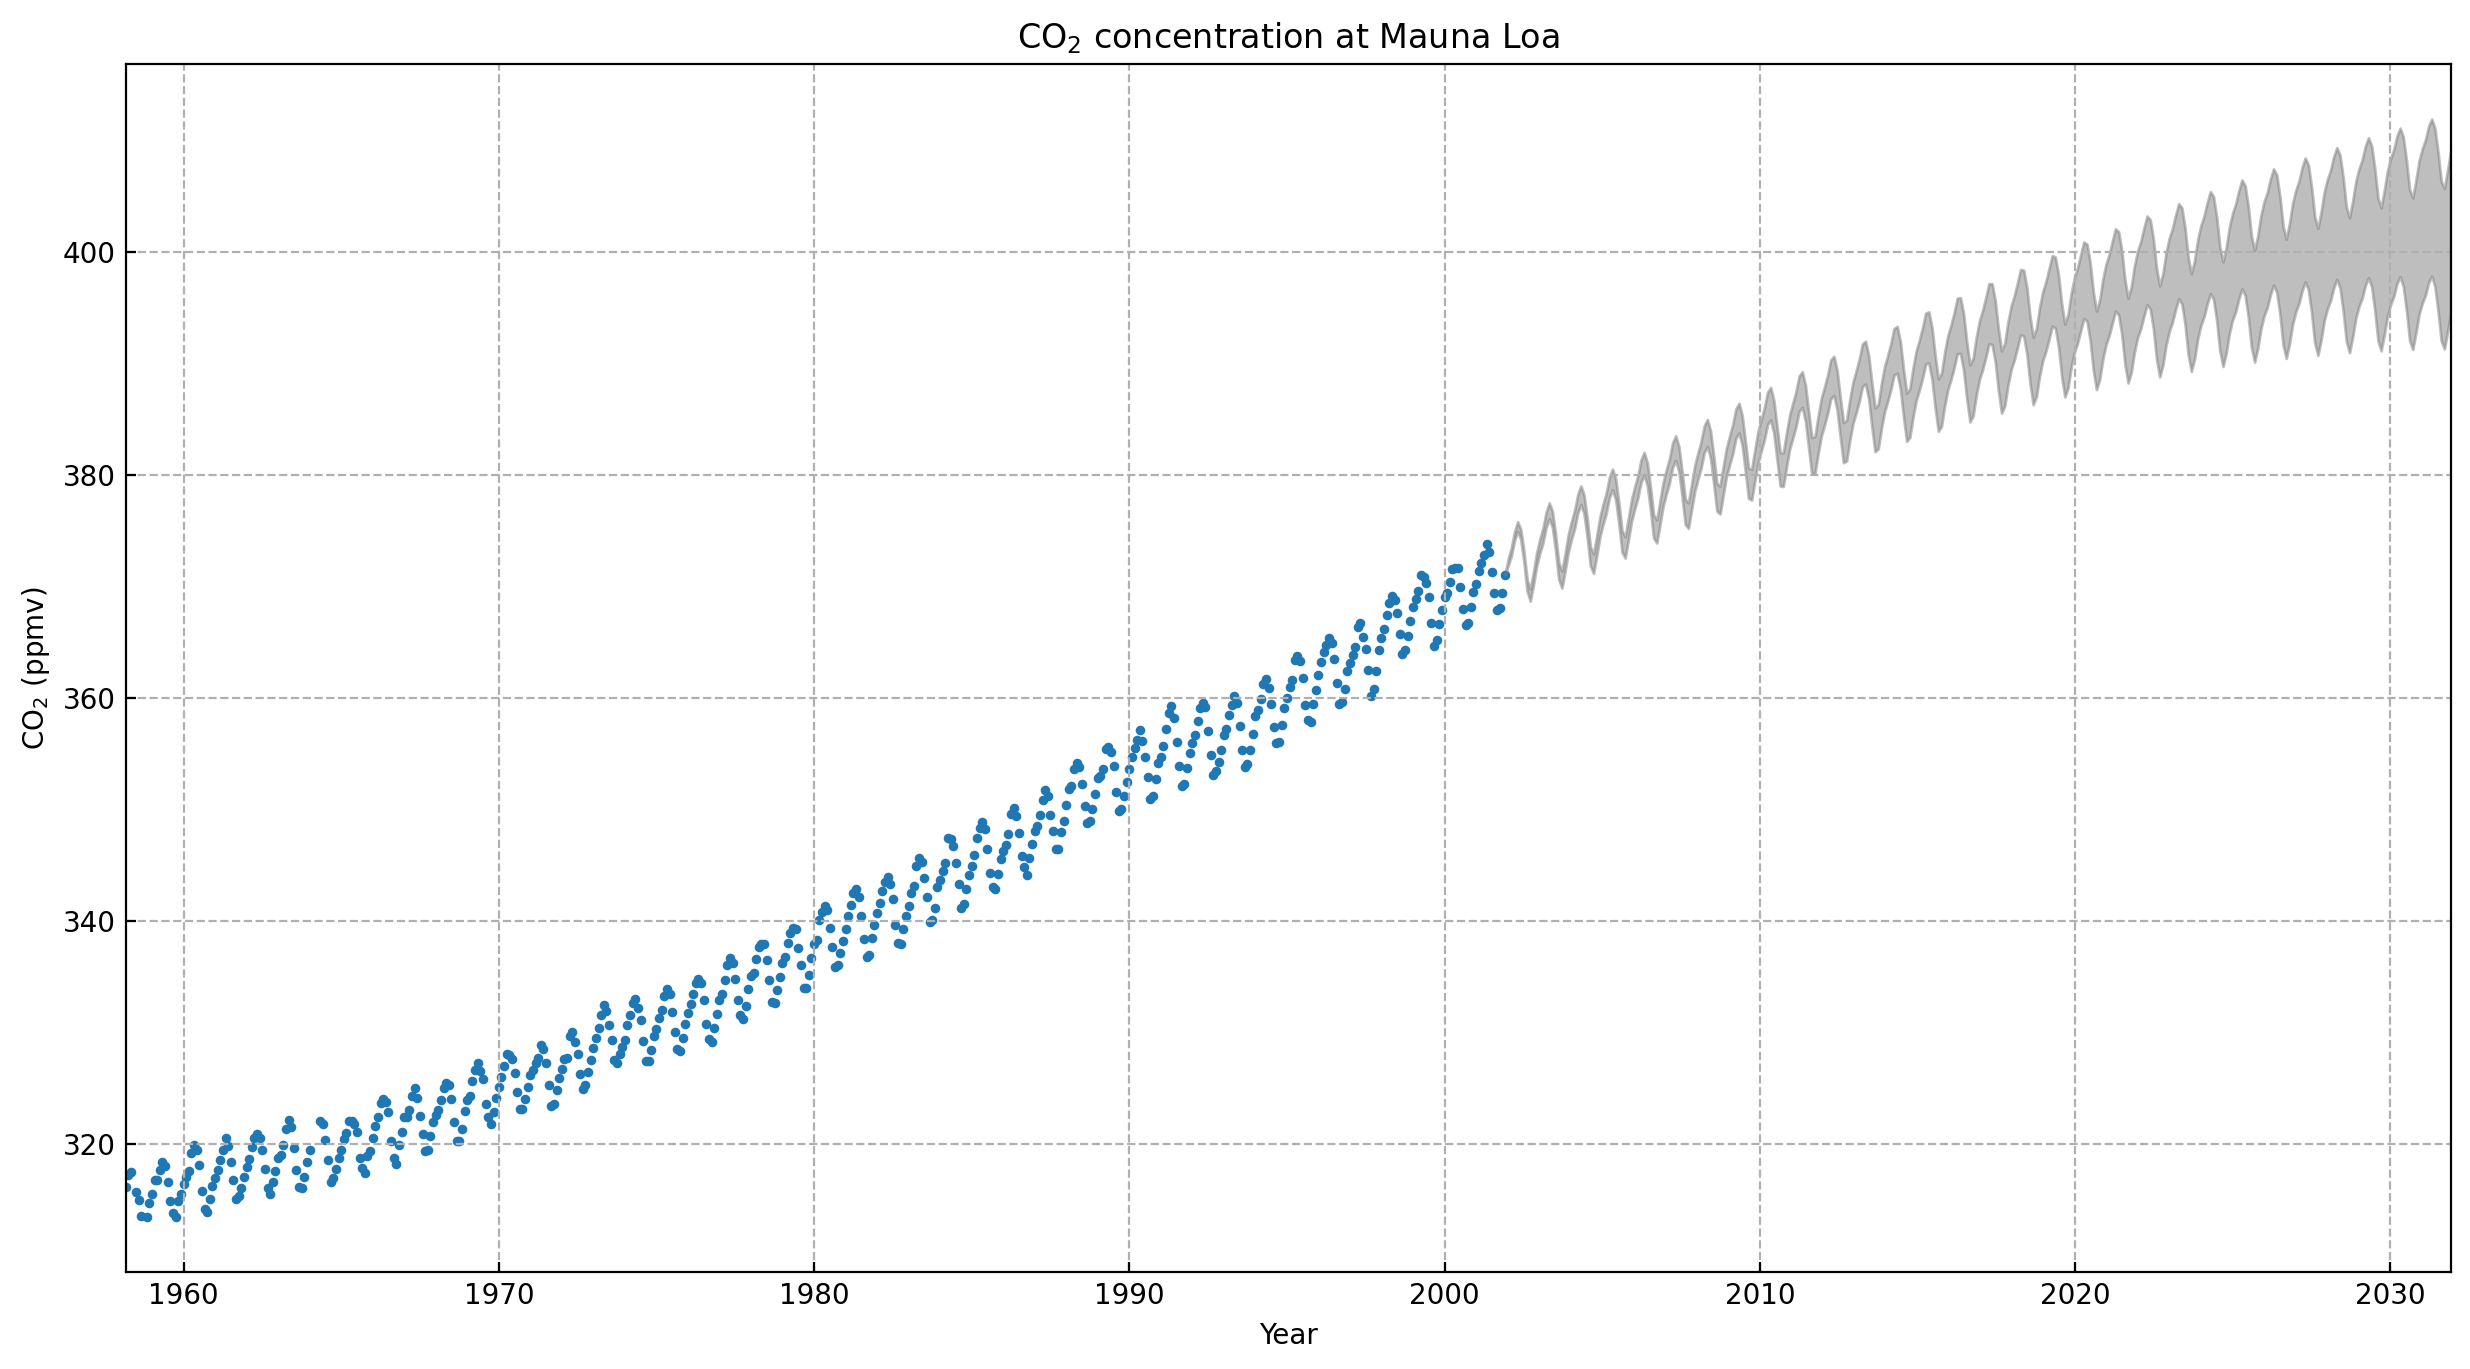

In [8]:
# visualization
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 200
# observed data
plt.scatter(X, y, s=6, c='tab:blue', marker='o') 
# prediction interval
plt.fill_between(X_[:, 0], 
                 y_mu_pred - y_std_pred,
                 y_mu_pred + y_std_pred,
                 alpha=0.5, color='tab:gray')
# layout
plt.grid(linestyle='--')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.xlim(X.min(), X_.max())
plt.xlabel('Year')
plt.ylabel('CO$_2$ (ppmv)')
plt.title('CO$_2$ concentration at Mauna Loa')
plt.show()